In [10]:
!pip install prophet

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import timedelta
from prophet import Prophet

In [12]:
df = pd.read_csv('Amazon Sale Report.csv', encoding='latin-1', low_memory=False)

In [13]:
# --- 1. Data Cleaning (The SQL DELETE/Cleanup Logic) ---
# Drop rows where 'Amount' is null or 'Date' is null
df_clean = df.dropna(subset=['Amount', 'Date']).copy()

# Convert the 'Date' column to datetime objects (needed for time series)
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%m/%d/%Y', errors='coerce')
df_clean = df_clean.dropna(subset=['Date']) # Clean up any dates that couldn't convert

# --- 2. Aggregate Daily Sales (The core data for forecasting) ---
daily_sales = df_clean.groupby('Date')['Amount'].sum().reset_index()
daily_sales.columns = ['Date', 'Total Sales Amount']

print("Data Cleaning and Aggregation Complete.")
print(f"Clean records count: {len(df_clean)}")
print("Daily Sales Data:")
print(daily_sales.head())

Data Cleaning and Aggregation Complete.
Clean records count: 121180
Daily Sales Data:
        Date  Total Sales Amount
0 2022-03-31           101683.85
1 2022-04-01           865478.60
2 2022-04-02           913101.53
3 2022-04-03          1011763.38
4 2022-04-04           882059.17


In [17]:
df_clean.to_csv('Amazon_Sales_Cleaned_For_PowerBI.csv', index=False, encoding='utf-8')
print("Cleaned data exported as Amazon_Sales_Cleaned_For_PowerBI.csv")

Cleaned data exported as Amazon_Sales_Cleaned_For_PowerBI.csv


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


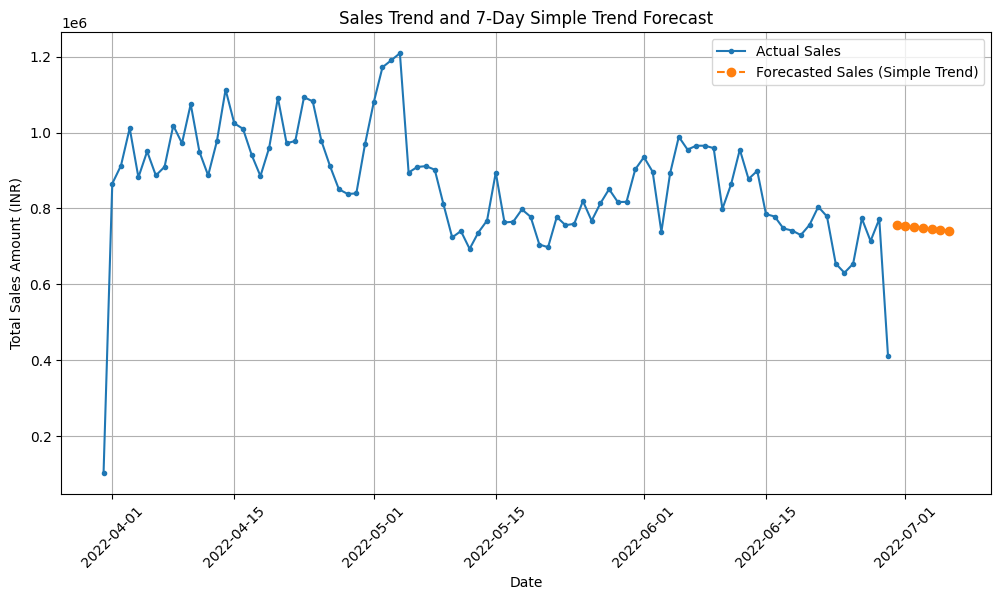


--- Final 7-Day Forecast ---
        Date  Forecasted Sales Amount
0 2022-06-30            755883.789458
1 2022-07-01            753540.919544
2 2022-07-02            751198.049630
3 2022-07-03            748855.179716
4 2022-07-04            746512.309803
5 2022-07-05            744169.439889
6 2022-07-06            741826.569975


In [15]:
# --- 1. Prepare Data for Model ---
daily_sales['Time_Index'] = np.arange(len(daily_sales))
X = daily_sales[['Time_Index']]
y = daily_sales['Total Sales Amount']

# --- 2. Build and Train Model ---
model = LinearRegression()
model.fit(X, y)

# --- 3. Forecast the Next 7 Days ---
last_day_index = daily_sales['Time_Index'].max()
forecast_indices = np.arange(last_day_index + 1, last_day_index + 8).reshape(-1, 1)
forecast_sales = model.predict(forecast_indices)

# Create the date range for the forecast period
last_date = daily_sales['Date'].max()
forecast_start_date = last_date + timedelta(days=1)
forecast_dates = pd.date_range(start=forecast_start_date, periods=7)

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted Sales Amount': forecast_sales
})

# --- 4. Visualize and Print Results ---
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['Date'], daily_sales['Total Sales Amount'], label='Actual Sales', marker='.', linestyle='-')
plt.plot(forecast_df['Date'], forecast_df['Forecasted Sales Amount'], label='Forecasted Sales (Simple Trend)', marker='o', linestyle='--')

plt.title('Sales Trend and 7-Day Simple Trend Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount (INR)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

print("\n--- Final 7-Day Forecast ---")
print(forecast_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


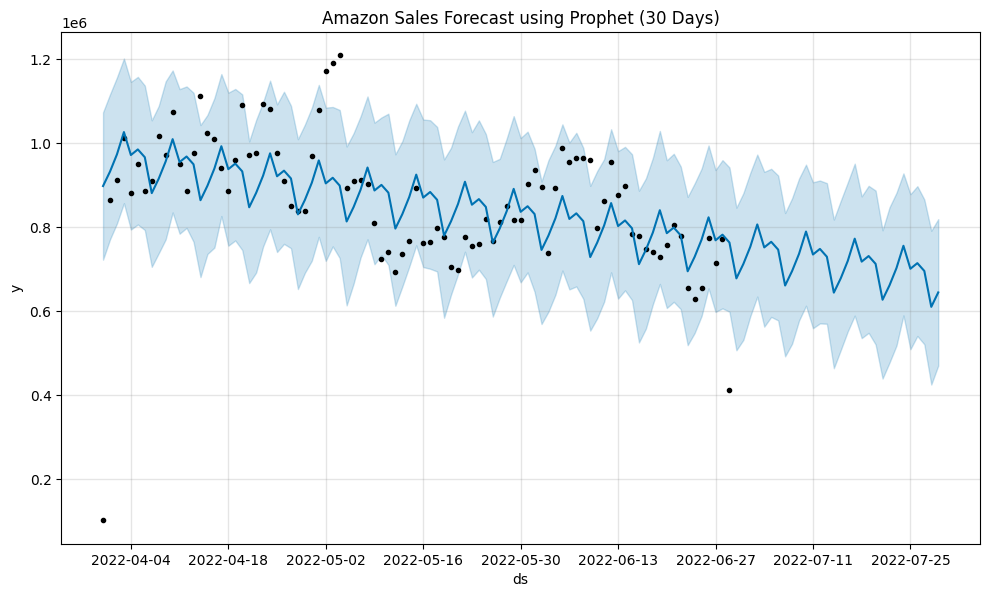


--- 7-Day Sales Forecast using Advanced Prophet Model ---
            ds           yhat
114 2022-07-23  702872.543692
115 2022-07-24  755953.304452
116 2022-07-25  701258.944328
117 2022-07-26  714578.489624
118 2022-07-27  695976.336053
119 2022-07-28  610487.619627
120 2022-07-29  644853.921615


In [16]:
# Assuming daily_sales DataFrame from our previous steps is still available

# 1. Rename columns to Prophet's required format (ds for Date, y for Sales)
prophet_df = daily_sales.rename(columns={'Date': 'ds', 'Total Sales Amount': 'y'})

# 2. Initialize the Prophet model
# We are telling Prophet we expect weekly seasonality in the sales data
model = Prophet(weekly_seasonality=True, daily_seasonality=False)

# 3. Fit (Train) the model on the historical data
model.fit(prophet_df)

# 4. Create a DataFrame for Future Dates (The forecast period)
# We will forecast the next 30 days to see a clearer trend
future = model.make_future_dataframe(periods=30)

# 5. Make the prediction!
forecast = model.predict(future)

# 6. Plot the forecast results
fig = model.plot(forecast)
plt.title('Amazon Sales Forecast using Prophet (30 Days)')
plt.show()

# 7. Show the forecasted sales for the next 7 days (the last 7 rows of the forecast)
print("\n--- 7-Day Sales Forecast using Advanced Prophet Model ---")
# The 'yhat' column is Prophet's prediction
print(forecast[['ds', 'yhat']].tail(7))